# Comment évoluent les relations entre les personnages de la saga Harry Potter?

###### Adrien Vallette et Sophie Vaillant

La saga Harry Potter est composée de 7 ouvrages, au cours desquels l'on suit les aventures du personnage principal. Si l'histoire est effectivement centrée sur Harry Potter, cette saga est également connue pour la variété de ses personnages, qu'il rencontre au cours des différents livres et avec lesquels il interagit. Il semble alors intéressant de se pencher sur ces interactions dont il est parfois difficile d'analyser l'évolution au cours d'une lecture subjective, et de les observer par le prisme du NLP. L'objectif de ce projet de programmation et ainsi de caractériser les interactions dans leur quantité et leur nature, et d'en analyser les évolutions au fil des livres.

Pour cela, nous aurons donc recours au Natural Language Processing, qui nous permettra d'extraire l'information de ces 7 livres qui représentent au total 199 chapitres, soit 1 084 170 mots. Nous utiliserons également l'analyse de sentiments pour caractériser les différentes interactions.

###### Packages et modules que nous utiliserons au cours de ce projet 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.collocations import *
try:
    stopwords = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))
import csv
import io


### Nettoyage des données 

Nous avons téléchargé les textes de chaque tome en anglais sur le lien suivant: https://github.com/formcept/whiteboard/tree/master/nbviewer/notebooks/data/harrypotter (nous vous invitons à les télécharger aussi pour pouvoir faire tourner le code en remplaçant les chemins par les vôtres).

##### Changement du format des textes pour pouvoir travailler dessus

In [2]:
#Tout d'abord, on crée un dictionnaire des différents tomes

Books = {"The Philosopher's Stone": '1',
        'The Chamber of Secrets': '2',
        'The Prisoner of Azkaban': '3',
        'The Goblet of Fire':'4',
        'The Order of the Phoenix': '5',
        'The Half Blood Prince': '6',
        'The Deathly Hallows': '7'}

In [4]:
#Création du CSV

def creation_csv(nom_livre,numero_livre):
    
    #Remplacez le chemin et la sortie par les vôtres
    
    #Adrien: 
    #chemin = r"C:\Users\adxva\OneDrive\Bureau\ENSAE 2A - S1\Harry-Python\Data\Books txt\Book " + numero_livre + " - "  + nom_livre + ".txt"
    #sortie = r"C:\Users\adxva\OneDrive\Bureau\ENSAE 2A - S1\Harry-Python\Data\Books CSV\Book " + numero_livre + ".csv"
    #Sophie: 
    chemin = r"C:\Users\Sophie\Harry-Python\Data\Book " + numero_livre + " - " + nom_livre + ".txt"
    sortie = r"C:\Users\Sophie\Harry-Python\Data\book" + numero_livre + ".csv"
    
    with io.open(chemin,"r",encoding="utf-8") as infile, open(sortie, 'w',encoding = 'utf-8-sig') as outfile:
        stripped = (line.strip() for line in infile)
        lines = (line.split(",") for line in stripped if line)
        writer = csv.writer(outfile)
        writer.writerows(lines)

In [5]:
#On fait une boucle exécutant la fonction sur chaque élément du dictionnaire

Books_csv = {}
for title, i in Books.items():
    creation_csv(title, i)
    #Remplacez à nouveau les chemins
    #Adrien:
    #Books_csv['book' + i] = pd.read_csv(r"C:\Users\adxva\OneDrive\Bureau\ENSAE 2A - S1\Harry-Python\Data\Books CSV\Book " + i + ".csv",encoding = 'utf-8-sig', sep='delimiter', header=None)
    # Sophie: 
    Books_csv['book' + i] = pd.read_csv(r"C:\Users\Sophie\Harry-Python\Data\book" + i + ".csv" ,encoding = 'utf-8-sig', sep='delimiter', header=None)

<ipython-input-5-710a0c02ec61>:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Books_csv['book' + i] = pd.read_csv(r"C:\Users\Sophie\Harry-Python\Data\book" + i + ".csv" ,encoding = 'utf-8-sig', sep='delimiter', header=None)


In [21]:
#Regardons ce que le CSV donne

Books_csv['book1'].head(100)

0
0                                                   /
1                                   THE BOY WHO LIVED
2   Mr. and Mrs. Dursley, of number four, Privet D...
3   were proud to say that they were perfectly nor...
4   thank you very much. They were the last people...
..                                                ...
95  perfectly normal, owl-free morning. He yelled ...
96  different people. He made several important te...
97  Page | 4 Harry Potter and the Philosophers Sto...
98  calls and shouted a bit more. He was in a very...
99  mood until lunchtime, when he thought he’d str...

[100 rows x 1 columns]

In [7]:
#On crée un tableau avec tous les livres

df_books = pd.DataFrame(Books_csv.items(), columns = ['Books', 'Text'])

##### Nettoyage des textes

On souhaite supprimer les lignes en fin de pages qui apparaissent systématiquement, du type "Page 7 Harry Potter and the Philosophers Stone J.K. Rowling".
Pour cela on crée un pattern.

Nous avons pu constater en parcourant les textes qu'ils comportaient des fautes d'orthographe (lorsque l'on comparait les titres de chapitres observés aux vrais titres par exemple), et parfois des O à la place des 0 par exemple, ce qui explique par la suite des patterns parfois alambiqués.

In [22]:
#On crée les patterns pour éliminer les lignes de fin de page qui reviennent dans chaque livre

pattern = ["Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Philosophers Stone[\s]?-[\s]?J.K. Rowling",
           "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Chamber of Secrets[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Prisoner of Azkaban[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Goblet of Fire[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[l0-9]?[lOU0-9]?[lOU0-9]?[lOU0-9][\s]?Harry Potter and the Order of the Phoenix[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Half Blood Prince[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Deathly Hallows[\s]?-[\s]?J.K. Rowling"]

In [23]:
#On crée une fonction permettant de supprimer ces lignes lorsque le pattern est rencontré au cours du texte

def clean_page(text, pattern):
    for ele in pattern:
        liste_regex = re.findall(ele, text, re.IGNORECASE)
        for expression in liste_regex:
            text = text.replace(expression, '') # On remplace les bas de pages par des espaces
    return text

In [24]:
#On crée le même dictionnaire en fusionnant chaque texte du CSV pour pouvoir appliquer la fonction

all_text = Books_csv.copy()
for i in Books_csv:
    all_text[i] = ' '.join([text for text in Books_csv[i][0]])

In [25]:
#On applique la fonction au dictionnaire des livres afin de supprimer les patterns que l'on rencontre

for i in all_text:
    all_text[i] = clean_page(all_text[i], pattern)

On réalise une tokenisation sur le texte pour garder une liste de mots et on supprime ceux qui ne nous intéressent pas (les "stopwords": the, a, etc).

In [26]:
#nltk.download('punkt')

all_text_clean = all_text.copy()

for i in all_text:
    
    text_list = nltk.tokenize.word_tokenize(all_text[i])
    text_list = [x.lower() for x in text_list]
    text_clean = [w.lower() for w in text_list if w not in stopwords and w.isalpha()]
    text_clean = ' '.join(text.lower() for text in text_clean)
    all_text_clean[i] = text_clean

In [27]:
#On regarde ce que ça donne sur un bout de texte

all_text_clean['book5'][:100]

'harry potter dudley demented hottest day summer far drawing close drowsy silence lay large square ho'

On obtient ainsi les données "all_text_clean" qui sont les textes nettoyés et regroupés en un dictionnaire.

### Statistiques descriptives

On veut regarder les mots qui reviennent le plus dans toute la saga: on réalise des wordclouds et des graphiques pour chaque tome.

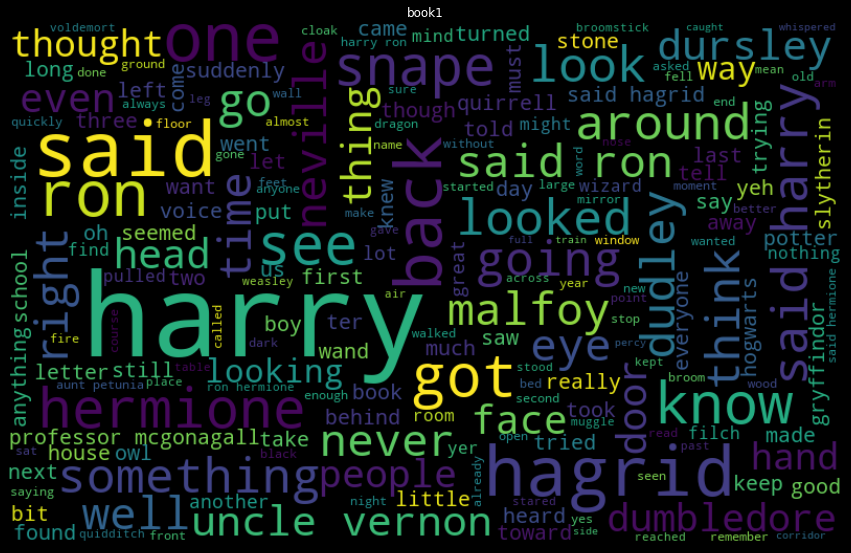

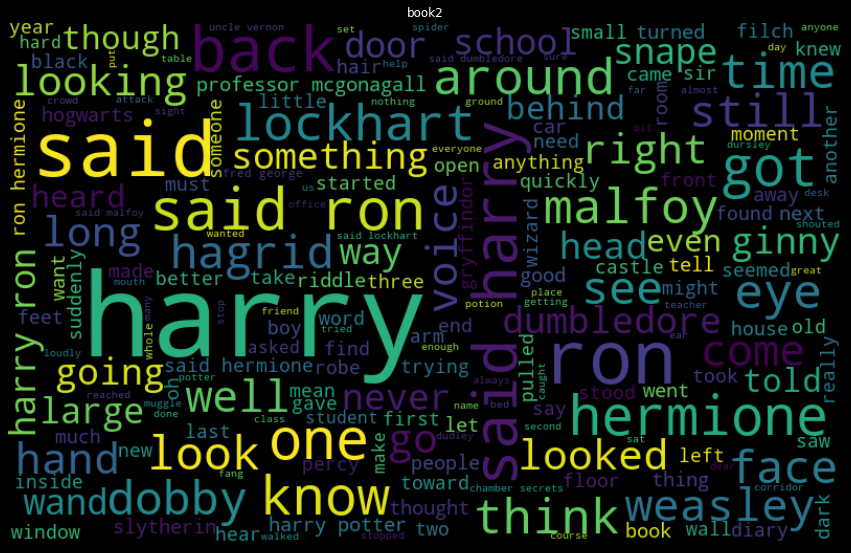

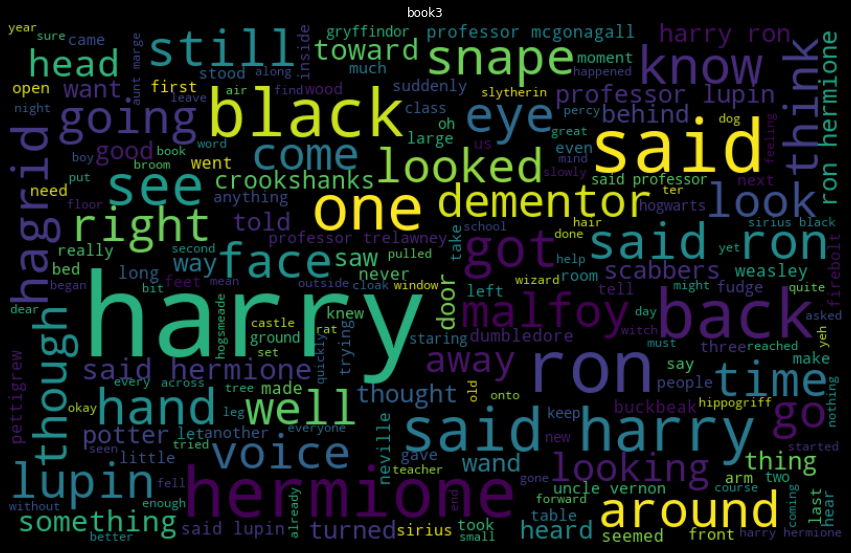

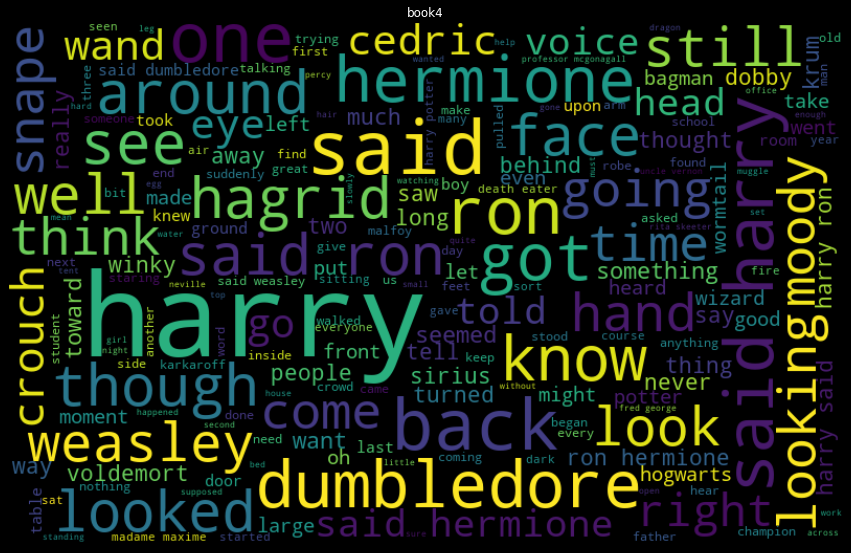

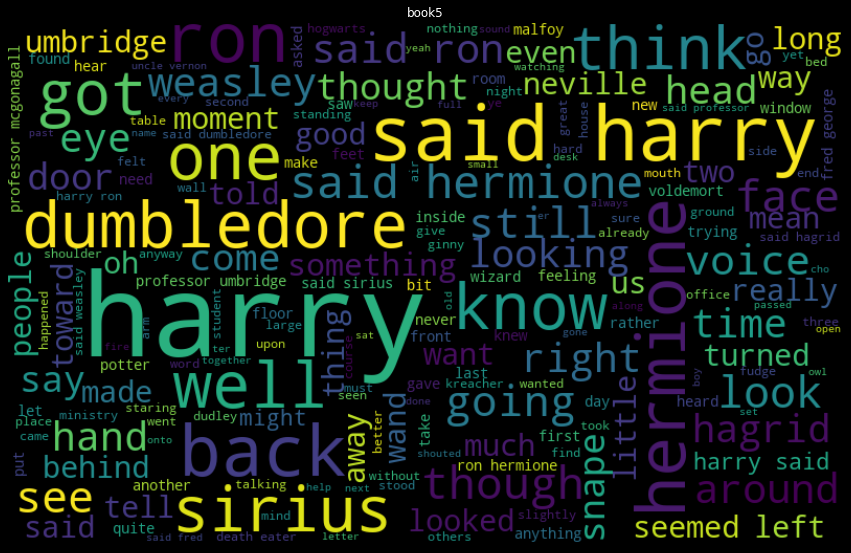

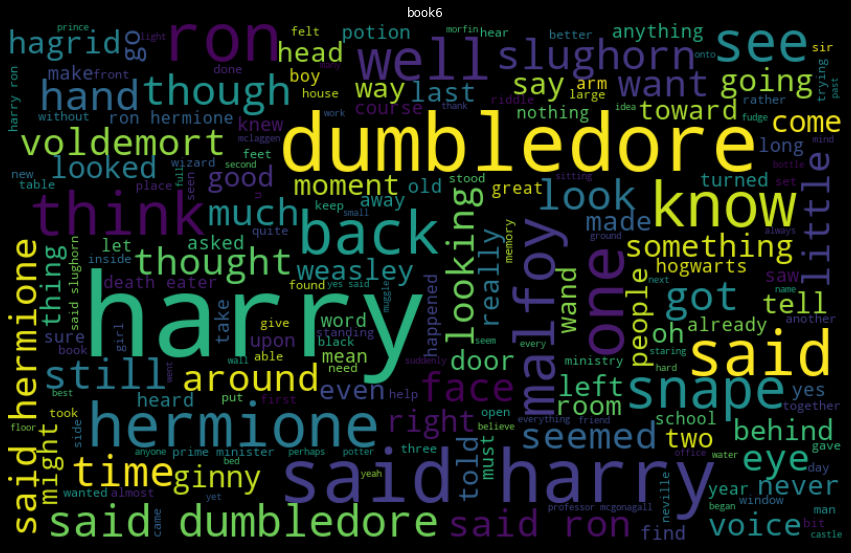

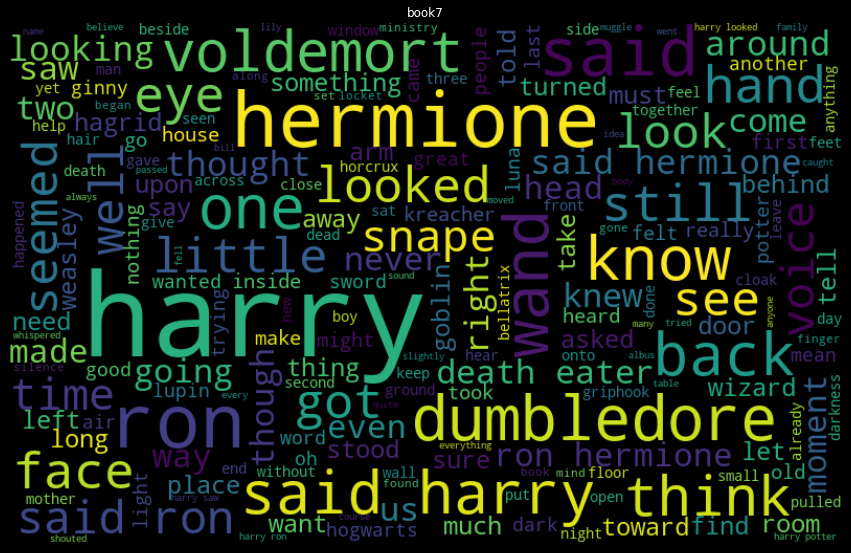

In [28]:
#Création des wordclouds

for i in all_text_clean:
    wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(all_text_clean[i])
    plt.figure(figsize=(15, 12))
    plt.title(i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off');

Les mots les plus fréquents ont l'air d'être principalement les noms de personnages. Le reste des mots ne donnent pas d'information particulière pour caractérisé les livres, ce sont des mots que l'on a l'habitude de retrouver dans des romans qui ne présente pas de tendance particulière. Ainsi, les interactions entre personnages semblent avoir une part centrale dans les ouvrages (forte présence de "said" également).

In [29]:
#On crée une fonction qui détermine les mots qui reviennent le plus dans un texte ainsi que leur nombre d'apparition

def most_common_word(text_clean):
    text_clean_list = text_clean.split()
    text_counts = Counter(text_clean_list)
    text_common_words = [word[0] for word in text_counts.most_common(25)]
    text_common_counts = [word[1] for word in text_counts.most_common(25)]

    return text_common_words, text_common_counts

In [30]:
#Création d'un dictionnaire avec les mots les plus utilisés par tome

hp_most_common = {}
for i in all_text_clean:
    hp_most_common[i] = most_common_word(all_text_clean[i])

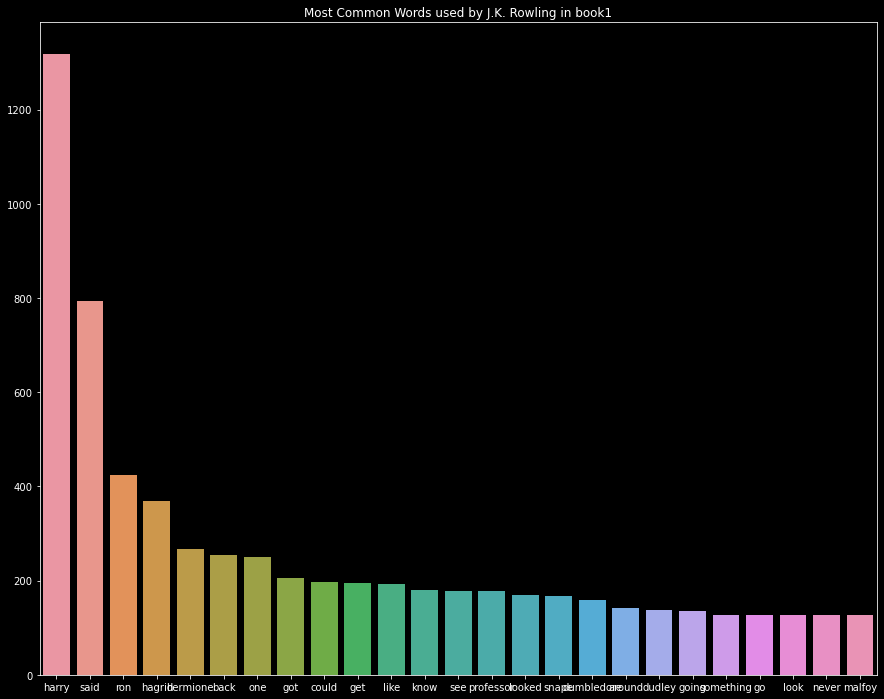

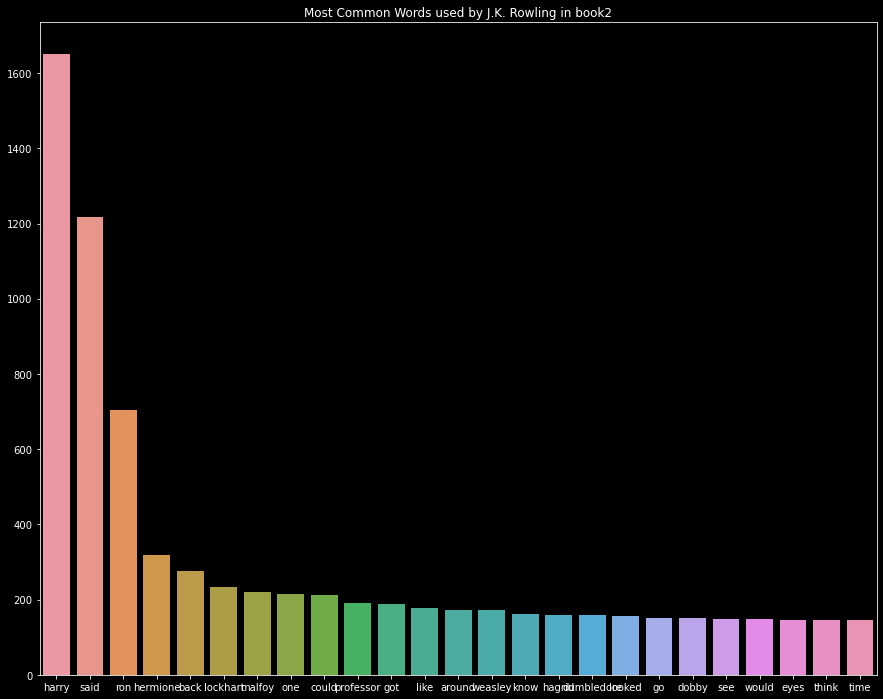

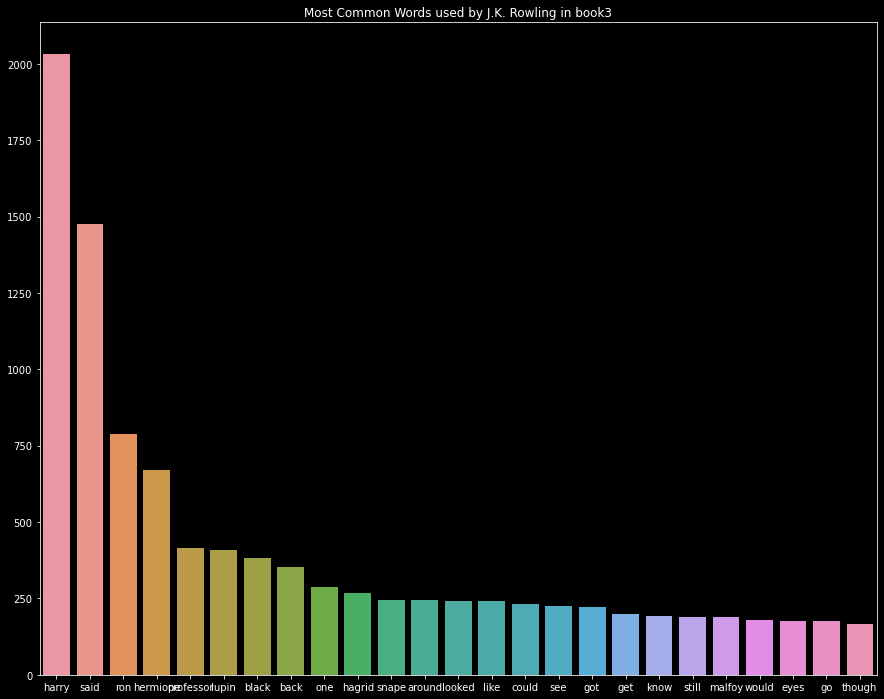

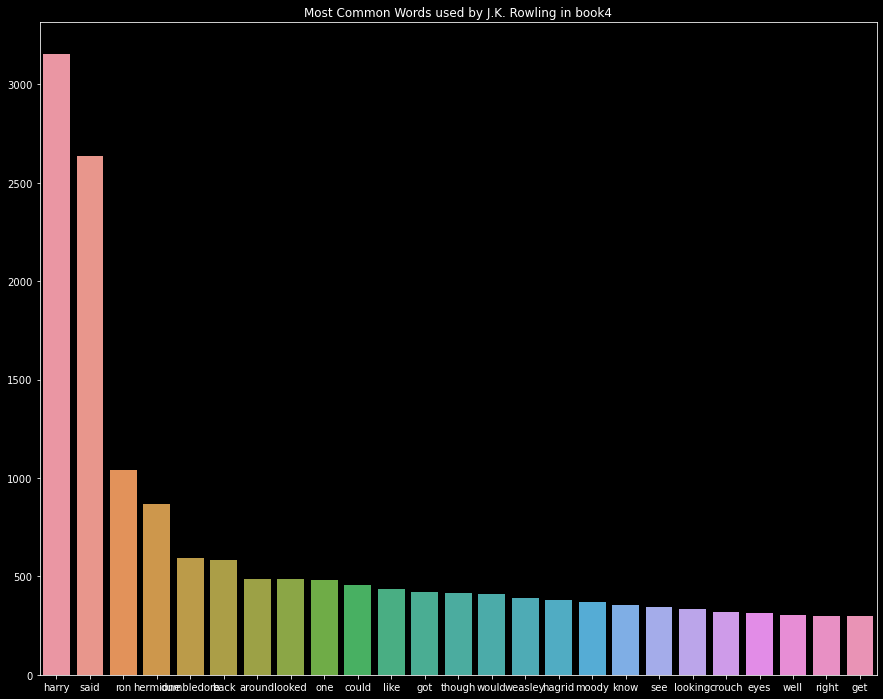

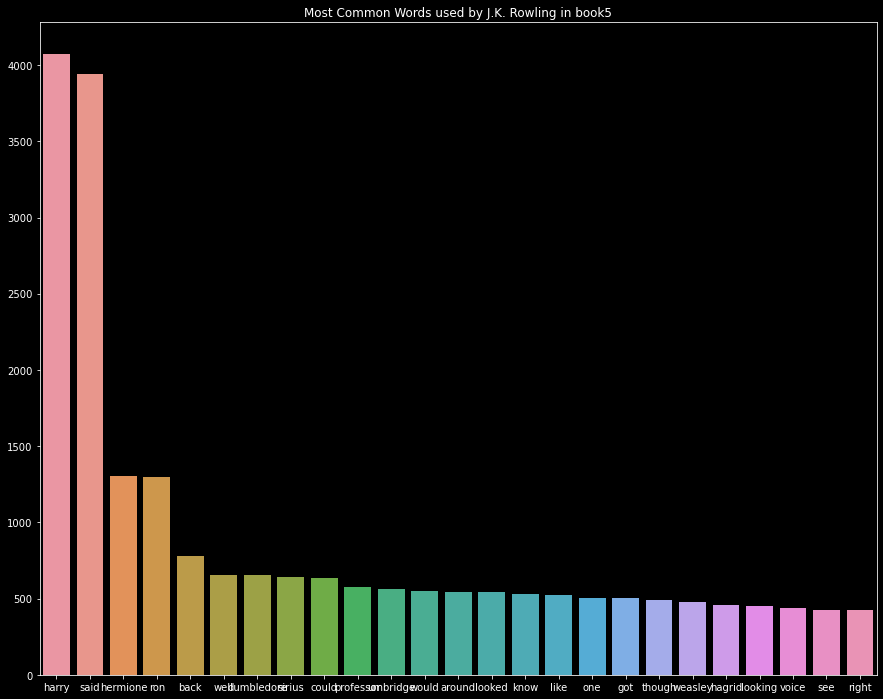

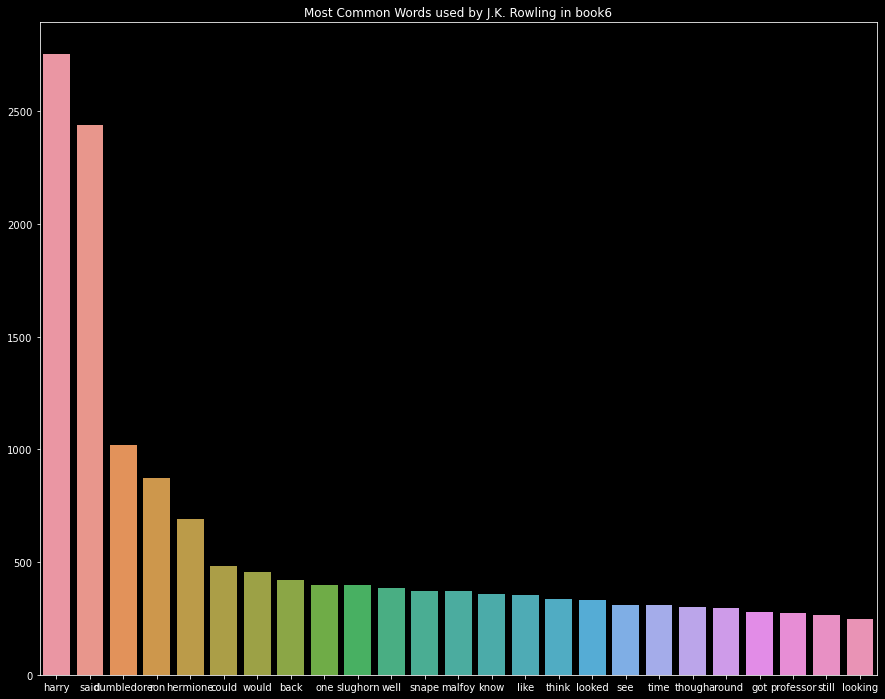

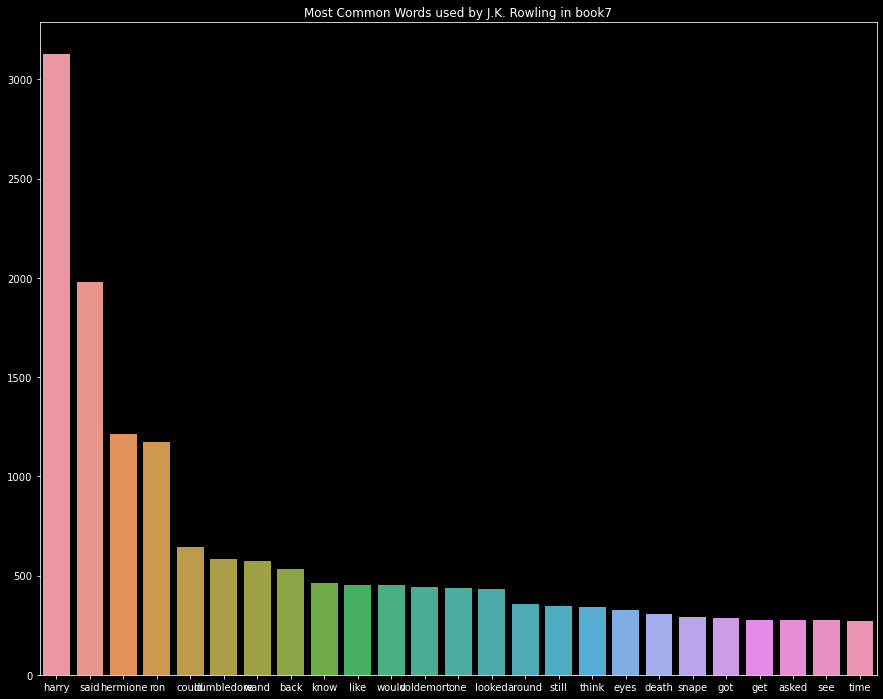

In [31]:
#On réalise les graphiques des mots les plus communs

for i in hp_most_common:
        plt.style.use('dark_background')
        plt.figure(figsize=(15, 12))
        words = hp_most_common[i][0]
        count = hp_most_common[i][1]
        sns.barplot(x = words, y = count)
        plt.title('Most Common Words used by J.K. Rowling in ' +i, color = 'white')

On constate de la même façon que les mots qui reviennent le plus sont des noms de personnages (Harry, Ron, Hagrid) et des mots classiques du récit qui ne nous apportent pas beaucoup d'information (said, like, know, go).

On va maintenant travailler plus spécifiquement sur les personnages. On définit une fonction qui comptabilise les noms propres pour en sortir ceux qui reviennent le plus.

In [32]:
def noms_propres(text):
    
# On mettra dans la fonction all_text qui n'est pas totalement nettoyé car il contient encore les majuscules qui aident 
# à détecter les noms propres (all_text_clean n'a plus de majuscules)
    
    text = nltk.word_tokenize(text) # On tokenize simplement le texte pour l'avoir sous forme de mots séparés et plus de string
    text = nltk.pos_tag(text)
    
    nnp = []
    noms = []
    noms_final = []
    
    for i,element in enumerate(text):
        if element[1] == "NNP" and len(element[0]) > 2 :
            nnp.append(element[0]) # On met tous les noms propres rencontrés dans une liste
    
    for nom in nnp:
        count = nnp.count(str(nom))
        noms.append([str(nom),count]) # On compte dans la liste combien de fois reviennent les noms propres
   
    noms = sorted(noms,key = lambda item: item[1], reverse = True)

    for i in noms:
        if i not in noms_final:
            noms_final.append(i)

    noms_final = noms_final[:10] # On ne regarde que les 10 plus fréquents
    
    return (noms_final)

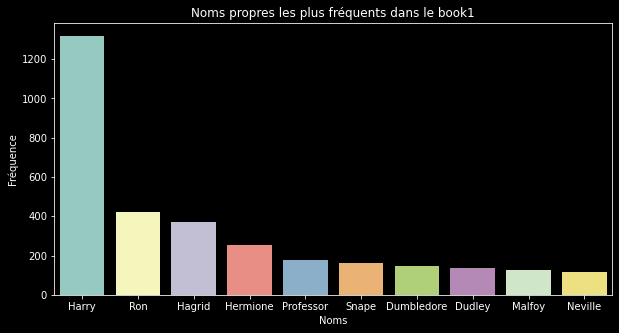

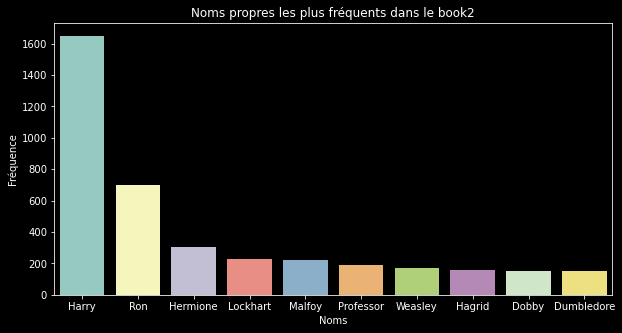

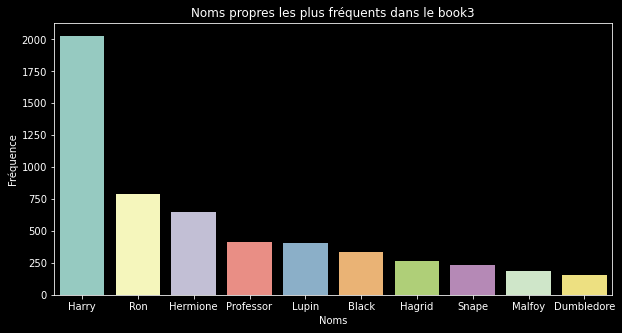

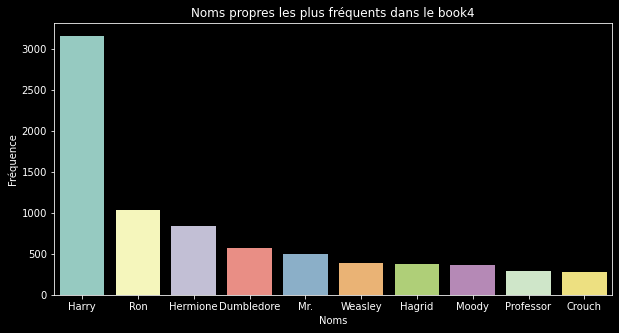

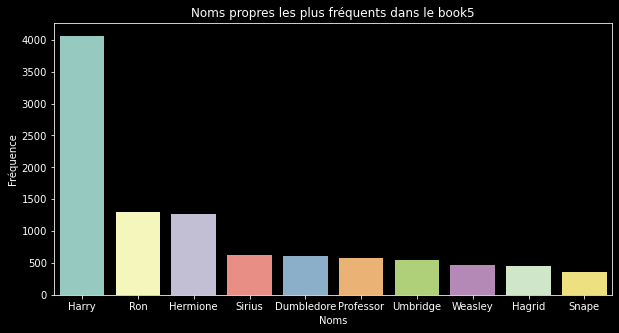

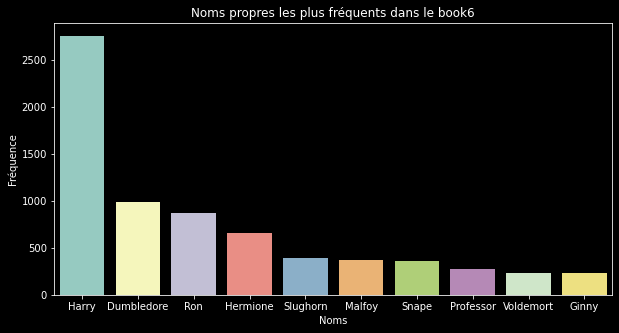

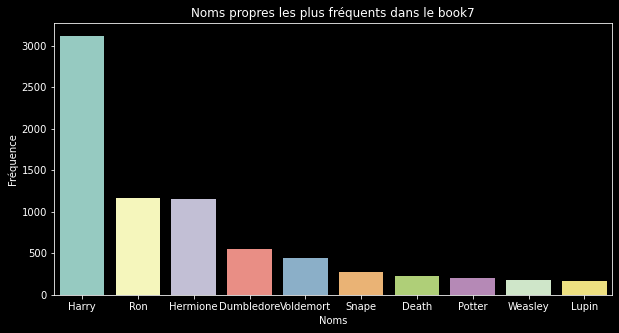

In [33]:
# On réalise des graphiques montrant les noms propres qui reviennent le plus dans chaque tome

noms_freq = []
for livre in all_text:
    plt.figure(figsize=(10, 5))
    df_freq_noms = pd.DataFrame(noms_propres(all_text[livre]), columns = ['Noms', 'Fréquence'])
    sns.barplot(x = df_freq_noms.Noms, y = df_freq_noms.Fréquence)
    plt.title('Noms propres les plus fréquents dans le ' +livre, color = 'white')

On constate sans surprise que les premiers noms sont toujours Harry, Ron et Hermione (sauf le tome 1 où Hermione est moins présente et le tome 6 où Dumbledore prend la 3ème place). Il y a des personnages que l'on retrouve dans chaque livre: Harry, Ron, Hermione, Dumbledore, Snape. Certains mots sont comptés comme des noms propres mais ne nous intéressent pas: Professor (s'il est suivi du nom de famille, il est déjà comptabilisé et s'il est utilisé seul dans du discours il est difficile de trouver la personne associée), Mr. (pour les mêmes raisons), Weasley (qui peut être associé à Ron, Ginny, leurs parents ou leurs frères qui seraient déjà comptabilisés par leurs prénoms).

##### Travail sur la relation entre les personnages 

Maintenant que nous savons quels sont les personnages qui apparaissent le plus dans les ouvrages, nous cherchons à distinguer et analyser leurs interactions. Dans la suite on ne garde que les personnages qui reviennent le plus souvent au total (qui sont dans les 10 plus fréquents de quasiment chaque tome).

In [34]:
# On regroupe les différentes formes sous lesquelles peuvent se retrouver les noms des personnages

harry = ['harry', 'harry potter']
ron = ['ron', 'ron weasley']
hermione = ['hermione granger','hermione']
ginny = ['ginny weasley', 'ginny']
dumbledore = ['albus dumbledore', 'dumbledore']
sirius = ['sirius black', 'sirius']
snape = ['severus snape', 'snape']
luna = ['luna lovegood', 'luna']
hagrid = ['rubeus hagrid', 'hagrid']
draco = ['draco','malfoy']
voldemort = ['tom riddle', 'voldemort', 'you-know-who', 'know-who', 'lord']

personnages = [harry,ron,hermione,ginny,dumbledore,sirius,snape,luna,voldemort]

In [38]:
#Fonction récupérant l'index de chaque apparition d'un personnage

def occurence(text_list, perso):
    occurence_all = []
    
    for i in text_list:
        occurence = []
        
        for idx, word in enumerate(text_list[i]):
            if word in perso:
                occurence.append(idx)
        occurence_all.append(occurence)
        
    return occurence_all

In [39]:
# On transforme le texte propre en une liste de mots

all_text_clean_list = all_text_clean.copy()
for i in all_text_clean:
    all_text_clean_list[i] = all_text_clean[i].split()

In [40]:
# On applique la fonction à chaque personnage qui nous intéresse

harry_occ = occurence(all_text_clean_list, harry)
ron_occ = occurence(all_text_clean_list, ron)
hermione_occ = occurence(all_text_clean_list, hermione)
ginny_occ = occurence(all_text_clean_list, ginny)
dumbledore_occ = occurence(all_text_clean_list, dumbledore)
sirius_occ = occurence(all_text_clean_list, sirius)
snape_occ = occurence(all_text_clean_list, snape)
luna_occ = occurence(all_text_clean_list, luna)
hagrid_occ = occurence(all_text_clean_list, hagrid)
draco_occ = occurence(all_text_clean_list, draco)
voldemort_occ = occurence(all_text_clean_list, voldemort)

###### On cherche à calculer un score de proximité entre les différents personnages et Harry Potter. 

In [41]:
def relation(perso_pdv, perso_cible):   #les arguments seront les listes d'occurences trouvées précédemment
    score_all = []
    
    for i in range(0,7): #on boucle sur tous les livres
        liens = 0   #compteur de liens
        list_index = []
        
        for idx in perso_pdv[i]:
            #on considère que deux personnages ont une interaction s'ils sont à moins de 20 mots d'écart
            idx_bas = idx - 20
            idx_haut = idx + 20
        
            for index in perso_cible[i]: 
                if (idx_bas <= index <= idx_haut):
                    liens += 1                     #si les index sont proches, on incrémente le compteur de liens
                    list_index.append([idx, index])
                    
        max_lien = float(len(perso_pdv[i])) #on calcule le nombre de liens potentiels ( = le nombre d'apparitions du personnage)
        liens_uniques = []
        
        for ele in list_index:
            if ele[0] not in liens_uniques:
                liens_uniques.append(ele[0]) 
        
        if max_lien != 0:
            score = ((len(liens_uniques) / max_lien)*100) #on fait le ratio entre le nombre de liens et le nombre de liens max
        else: score = 0
        
        score_all.append(score) #on stocke le score de chaque livre
        
    return score_all

In [42]:
# On applique la fonction au trio principal

harry2ron = relation(harry_occ, ron_occ)
ron2harry = relation(ron_occ, harry_occ) # On regarde les deux points de vue pour chaque relation
harry2hermione = relation(harry_occ, hermione_occ)
hermione2harry = relation(hermione_occ, harry_occ)
ron2hermione = relation(ron_occ, hermione_occ)
hermione2ron = relation(hermione_occ, ron_occ)

In [43]:
# On l'applique aussi aux autres personnages 

harry2sirius = relation(harry_occ, sirius_occ)
harry2dumbledore = relation(harry_occ, dumbledore_occ)
harry2snape = relation(harry_occ, snape_occ)
harry2voldemort = relation(harry_occ, voldemort_occ)
harry2ginny = relation(harry_occ, ginny_occ)
harry2hagrid = relation(harry_occ, hagrid_occ)
harry2draco = relation(harry_occ,draco_occ)
sirius2harry = relation(sirius_occ, harry_occ)
dumbledore2harry = relation(dumbledore_occ, harry_occ)
snape2harry = relation(snape_occ, harry_occ)
voldemort2harry = relation(voldemort_occ, harry_occ)
ginny2harry = relation(ginny_occ, harry_occ)
hagrid2harry = relation(hagrid_occ, harry_occ)
draco2harry = relation(draco_occ,harry_occ)

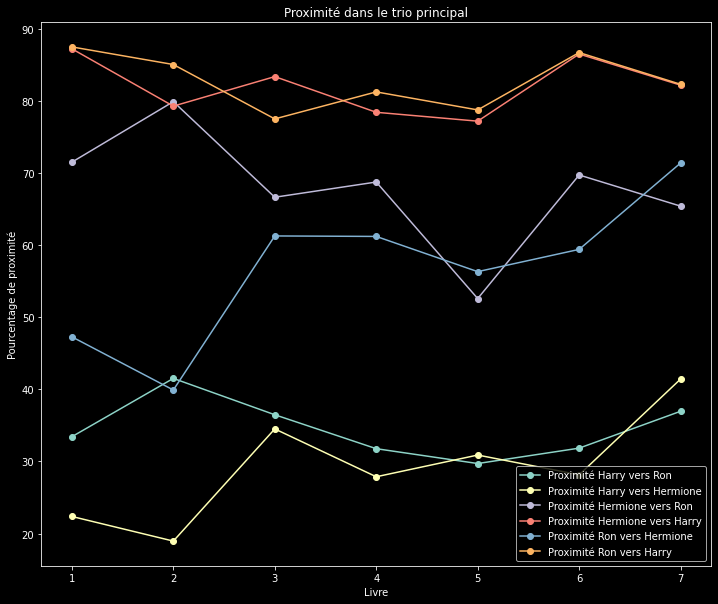

In [44]:
# On représente ces relations sous forme de graphiques

x = np.linspace(1,7,7)
plt.figure(figsize=(12,10))
plt.plot(x, harry2ron, marker = 'o', label = 'Proximité Harry vers Ron')
plt.plot(x, harry2hermione, marker = 'o', label = 'Proximité Harry vers Hermione')
plt.plot(x, hermione2ron, marker = 'o', label = 'Proximité Hermione vers Ron')
plt.plot(x, hermione2harry, marker = 'o', label = 'Proximité Hermione vers Harry')
plt.plot(x, ron2hermione, marker = 'o', label = 'Proximité Ron vers Hermione')
plt.plot(x, ron2harry, marker = 'o', label = 'Proximité Ron vers Harry')
plt.legend(loc = 'best', prop = {'size': 10})
plt.title('Proximité dans le trio principal', color = 'white')
plt.xlabel('Livre')
plt.ylabel('Pourcentage de proximité')
plt.show()

On remarque que les proximités les plus élevées sont celles de Ron et Hermione vers Harry, ce qui semble logique: quand ces personnages apparaissent, ils sont souvent à proximité du personnage principal là où Harry a plus de chances d'apparaitre dans des contextes différents (seul par exemple), du fait de la focalisation interne du récit. La relation Ron-Hermione est également intéressante à étudier: la proximité d'Hermione vers Ron est élevée dans chaque livre alors que celle de Ron vers Hermione augmente à partir du tome 3. On peut l'expliquer en considérant Ron comme le personnage "secondaire": il est le 2ème plus fréquent d'après les graphiques que nous avons vu dans chaque tome, il apparait donc plus souvent qu'Hermione et a ainsi plus de chances d'avoir des interactions sans Hermione.

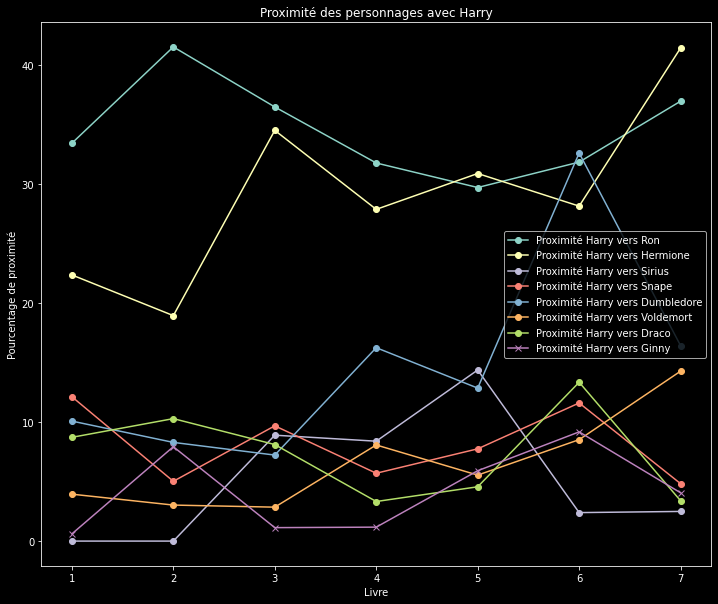

In [45]:
# On regarde le graphique des autres relations du point de vue d'Harry

x = np.linspace(1,7,7)
plt.figure(figsize=(12,10))
plt.plot(x, harry2ron, marker = 'o', label = 'Proximité Harry vers Ron')
plt.plot(x, harry2hermione, marker = 'o', label = 'Proximité Harry vers Hermione')
plt.plot(x, harry2sirius, marker = 'o', label = 'Proximité Harry vers Sirius')
plt.plot(x, harry2snape, marker = 'o', label = 'Proximité Harry vers Snape')
plt.plot(x, harry2dumbledore, marker = 'o', label = 'Proximité Harry vers Dumbledore')
plt.plot(x, harry2voldemort, marker = 'o', label = 'Proximité Harry vers Voldemort')
plt.plot(x, harry2draco, marker = 'o', label = 'Proximité Harry vers Draco')
plt.plot(x, harry2ginny, marker = 'x', label = 'Proximité Harry vers Ginny')
plt.legend(loc = 'best', prop = {'size': 10})
plt.title('Proximité des personnages avec Harry', color = 'white')
plt.xlabel('Livre')
plt.ylabel('Pourcentage de proximité')
plt.show()

On retrouve les résultats du graphique précédent montrant les noms propres les plus fréquents: Ron et Hermione ont les plus forts pourcentages de proximité avec Harry, sauf dans le 6 où Dumbledore dépasse Hermione. Cela démontre que l'apparition des personnages au cours des livres sont totalement conditionnées par leur relation avec le personnage principal.

### Modélisation des données 

Maintenant que nous avons une idée des interactions qui existent entre les personnages, on cherche à caractériser ces dernières car elles n'ont pas la même nature selon les personnages ou selon les tomes. Pour cela, nous allons avoir recours à l'analyse de sentiments.

In [46]:
# On a 20 relations: 9 avec Harry-autre perso, 2 Ron-Hermione et inversement, et 9 autre perso-Harry
# On crée un dictionnaire avec pour chaque livre les personnages de départ, les personnages d'arrivée et le poids de leur relation associée

perso_depart = [harry[1]]*9 + [ron[1], hermione[1], ron[1], hermione[1], ginny[1], draco[1], voldemort[1], sirius[1], snape[1], dumbledore[1], hagrid[1]]
persos_arrivee = [ron[1], hermione[1], ginny[1], draco[1], voldemort[1], sirius[1], snape[1], dumbledore[1], hagrid[1], hermione[1], ron[1]] + [harry[1]]*9

data_persos = {}

for i in range(7):
    data_persos['book' + str(i+1)] = {'perso depart': perso_depart, 'persos arrivee': persos_arrivee,
            'poids': [int(harry2ron[i]), int(harry2hermione[i]), int(harry2ginny[i]), int(harry2draco[i]), int(harry2voldemort[i]), int(harry2sirius[i]), int(harry2snape[i]), int(harry2dumbledore[i]), int(harry2hagrid[i]),
            int(ron2hermione[i]), int(hermione2ron[i]), int(ron2harry[i]), int(hermione2harry[i]), int(ginny2harry[i]), int(draco2harry[i]), int(voldemort2harry[i]), int(sirius2harry[i]), int(snape2harry[i]), int(dumbledore2harry[i]), int(hagrid2harry[i])]
                                    }

In [47]:
# On crée le tableau qui permettra de générer les réseaux de personnages de chaque tome

df1 = pd.DataFrame(data_persos['book1'], columns = {'persos arrivee', 'poids', 'perso depart'})
df2 = pd.DataFrame(data_persos['book2'], columns = {'persos arrivee', 'poids', 'perso depart'})
df3 = pd.DataFrame(data_persos['book3'], columns = {'persos arrivee', 'poids', 'perso depart'})
df4 = pd.DataFrame(data_persos['book4'], columns = {'persos arrivee', 'poids', 'perso depart'})
df5 = pd.DataFrame(data_persos['book5'], columns = {'persos arrivee', 'poids', 'perso depart'})
df6 = pd.DataFrame(data_persos['book6'], columns = {'persos arrivee', 'poids', 'perso depart'})
df7 = pd.DataFrame(data_persos['book7'], columns = {'persos arrivee', 'poids', 'perso depart'})

In [48]:
# On crée une liste des occurences pour chaque personnage. Chaque élément de occ_list est la liste des occurences d'un tome

occ_list = []
for i in range(7):
    occ_list.append([len(harry_occ[i]), len(ron_occ[i]), len(hermione_occ[i]), len(ginny_occ[i]), len(draco_occ[i]),
             len(voldemort_occ[i]), len(sirius_occ[i]), len(snape_occ[i]), len(dumbledore_occ[i]), len(hagrid_occ[i])])

In [49]:
# On définit les fonctions de somme des éléments d'une liste et de moyenne d'une liste qui nous seront utiles par la suite

def somme(liste):
    _somme = 0
    for i in liste:
        _somme = _somme + i
    return _somme

def moyenne(liste):
    return somme(liste)/len(liste)

On va utiliser le package VADER pour l'analyse des sentiments, pour obtenir un score de positivité entre -1 (extrêmement négatif) et 1 (extrêmement positif). Puis, on crée une fonction qui permet de donner le score de positivité par tome de toutes les relations d'un personnage, en faisant la moyenne du score des groupes de mots à proximité des deux personnages (on a défini précédemment qu'il y a un lien entre deux personnages, s'ils se retrouvent tous les deux dans un rayon de 20 mots).

In [51]:
#package pour l'analyse des sentiments
#!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_model = SentimentIntensityAnalyzer()

In [52]:
def rel_tome(perso_pdv, list_perso_occ):   #les arguments sont les listes d'index trouvées précédemment

    all_book_score = []
    i = 0
    
    for key in all_text_clean_list:
        all_score_tome = []
        list_index = []

        for perso in list_perso_occ:
                score_perso = []
                
                for idx in perso_pdv[i]:
        #on considère que deux personnages ont une interaction s'ils sont à moins de 20 mots d'écart
                    idx_bas = idx - 20
                    idx_haut = idx + 20
        
            
                    for index in perso[i]: 
                        if (idx_bas <= index <= idx_haut):
                        #liens += 1                     #si les index sont proches, on incrémente le compteur de liens
                            list_index.append([idx, index])

                            grp = [word for word in all_text_clean_list[key] [min([idx, index])-20:max([idx, index])+20]]
                            grp_join = ' '.join(grp)
                            score = sentiment_model.polarity_scores(grp_join)
                            compound_score = score['compound']
                            score_perso.append(compound_score)
                if len(score_perso)!= 0:
                    all_score_tome.append(moyenne(score_perso))
                else: all_score_tome.append(0)
        i += 1
        all_book_score.append(all_score_tome)
        
    return all_book_score

In [53]:
#On calcule les scores des relations d'Harry Potter (avec les 9 autres personnages) et celle entre Hermione et Ron

persos_occ_1 = [ron_occ, hermione_occ, ginny_occ, draco_occ, voldemort_occ, sirius_occ, snape_occ, dumbledore_occ,  hagrid_occ]

scores_rel_hp = rel_tome(harry_occ, persos_occ_1)
scores_rel_rh = rel_tome(ron_occ, [hermione_occ])

In [54]:
#On veut des noeuds de couleur selon la positivité totale de la relation (moyenne sur les livres)

scores_pers = []
a = []
for i in range(9):
    for j in range(7):
        a.append(scores_rel_hp[j][i])
    scores_pers.append(a)
    a = []
#scores_pers

In [55]:
#On obtient la liste qui donnera la couleur des noeuds, le 5 correspond à la moyenne arrondie pour Harry Potter.

scores_rel_total = [5]
for i in range(9):
    scores_rel_total.append(int(100*moyenne(scores_pers[i])))
scores_rel_total

[5, 13, 11, 13, 3, -13, 3, -5, 14, 8]

On définit enfin la fonction qui va créer et afficher le graphique en réseau des relations d'Harry Potter.
On utilise pour cela le module networkx qui permet de créer des noeuds et des liens entre eux ainsi que leurs caractéristiques (poids, taille, couleur).

In [59]:
scores_rel_hp

[[0.1951430434782606,
  0.1026548780487805,
  0.38218888888888886,
  0.050442408376963364,
  -0.3452131147540985,
  0,
  -0.05288400000000004,
  0.38473227513227526,
  0.2217877513711151],
 [0.1291331526648601,
  0.14543341288782824,
  0.17326397849462377,
  0.12263864306784648,
  0.00643908045977019,
  0,
  0.13521897810218977,
  0.16156454545454543,
  0.10060044444444435],
 [0.07586837169650473,
  0.07465947006869487,
  -0.07515862068965527,
  0.0387257627118644,
  -0.07674777777777772,
  -0.023432178217821825,
  -0.012257643312101912,
  0.2286163366336635,
  0.049087463556851334],
 [0.19969197127937327,
  0.2256821749795585,
  0.04766530612244896,
  0.0162127272727273,
  -0.24501065759637183,
  0.19192160804020097,
  -0.17085464480874304,
  0.15060513739546022,
  0.28818347639484926],
 [0.13231093916755604,
  0.11284662045060657,
  0.10318151815181521,
  0.07703069620253164,
  -0.19048544303797474,
  0.02318505494505486,
  0.08509280821917825,
  -0.0628582716049383,
  0.138051445086

In [62]:
def reseau(df, occ_list, i):
    f= plt.figure(1,figsize=(14,14))
    
    #on crée les noeuds
    G = nx.from_pandas_edgelist(df, 'perso depart', 'persos arrivee', edge_attr = True, create_using=nx.MultiDiGraph())
    pos=nx.spring_layout(G) #on les place dans l'espace
    node_sizes = [7*j for j in occ_list] #on choisit leur taille
    #On choisit la couleur des flèches
    edge_colors = [int(s*100) for s in scores_rel_hp[i-1]]
    edge_colors.extend([int(100*scores_rel_rh[i-1][0]), int(100*scores_rel_rh[i-1][0])])
    edge_colors.extend([int(s*100) for s in scores_rel_hp[i-1]])
    
    edge_labels=dict([((u,v,),d['poids'])
                      for u,v,d in G.edges(data=True)]) #on légende les flèches 
    #on trace le réseau
    nx.draw_networkx_edges(G, pos, arrows = True )
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, label_pos = 0.35)
    nx.draw(G,pos, node_color = scores_rel_total, cmap = plt.cm.coolwarm, edge_color = edge_colors, width = taille[i-1], node_size = node_sizes, edge_cmap=plt.cm.coolwarm, arrows=False)
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    plt.title('Réseau des relations avec Harry Potter dans le tome %i' %i, color = 'black')
    plt.show()
    return G

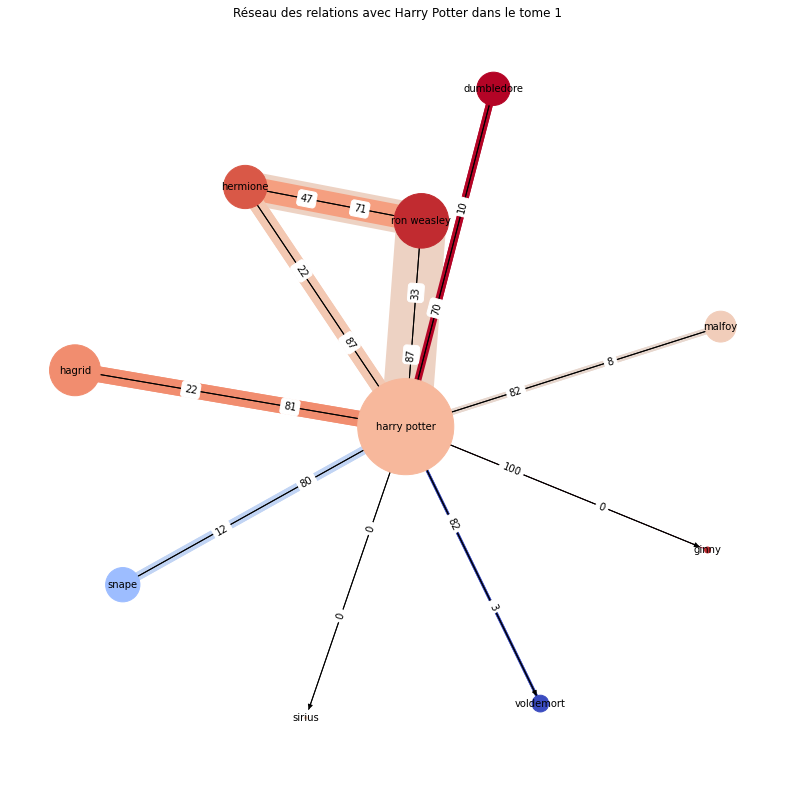

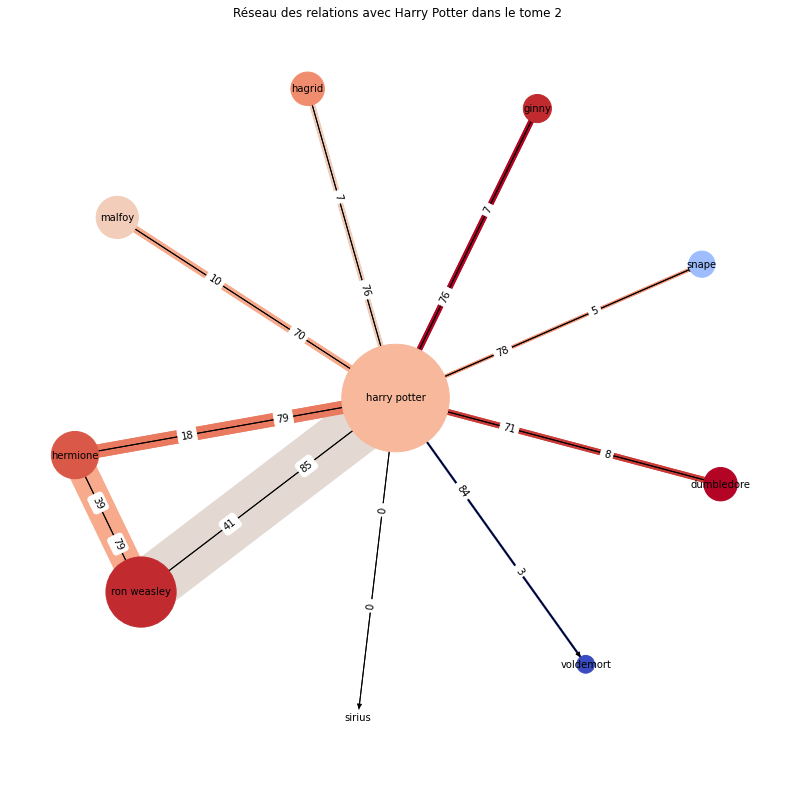

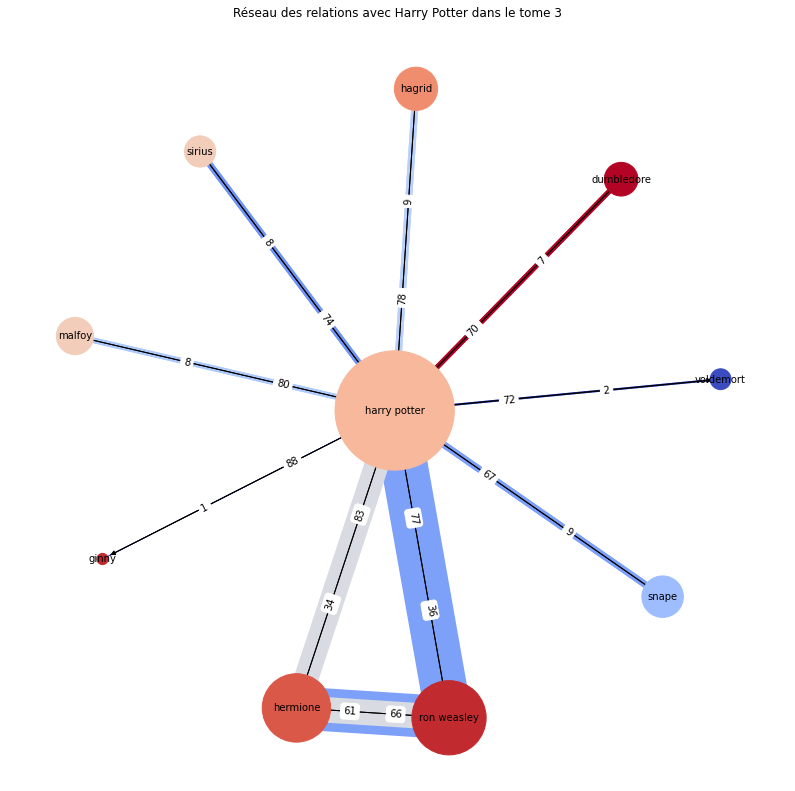

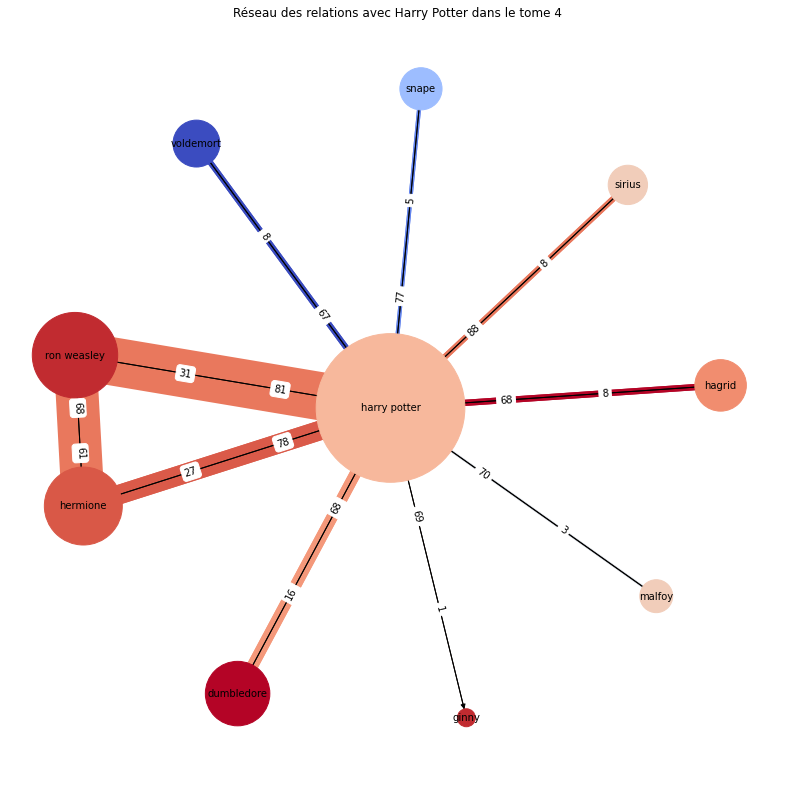

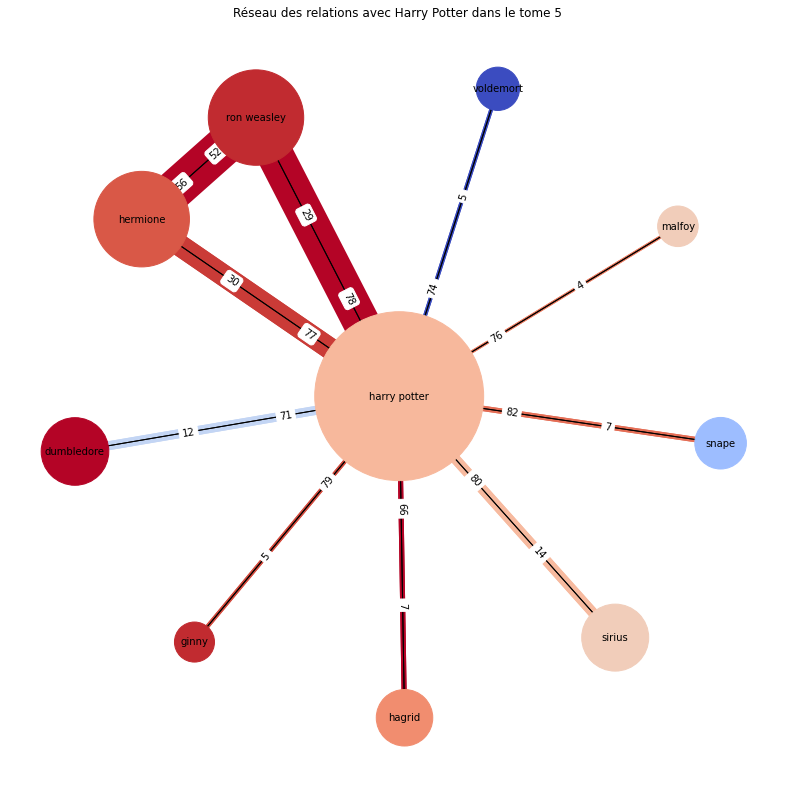

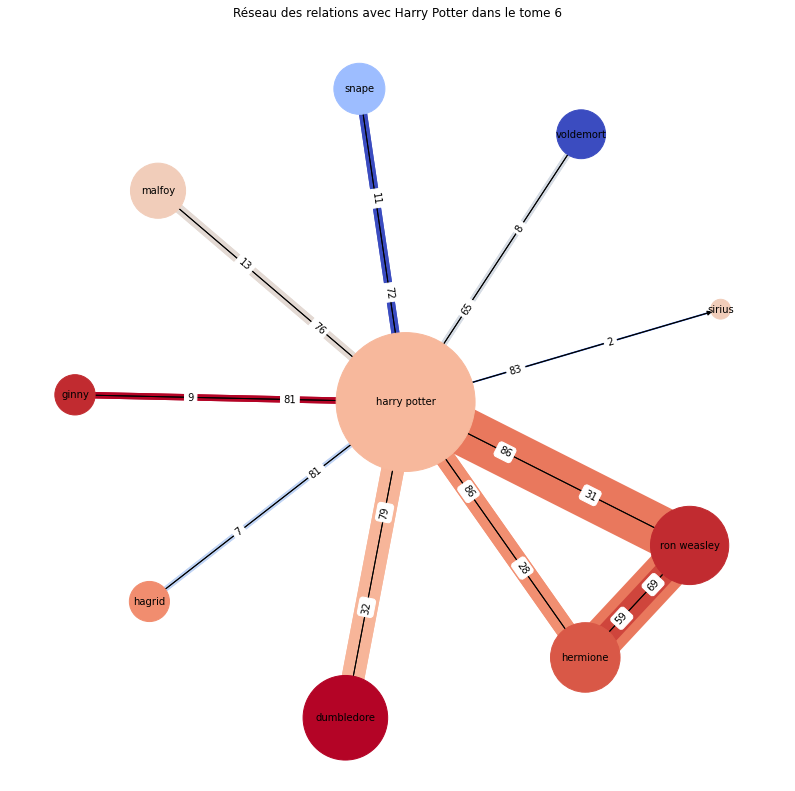

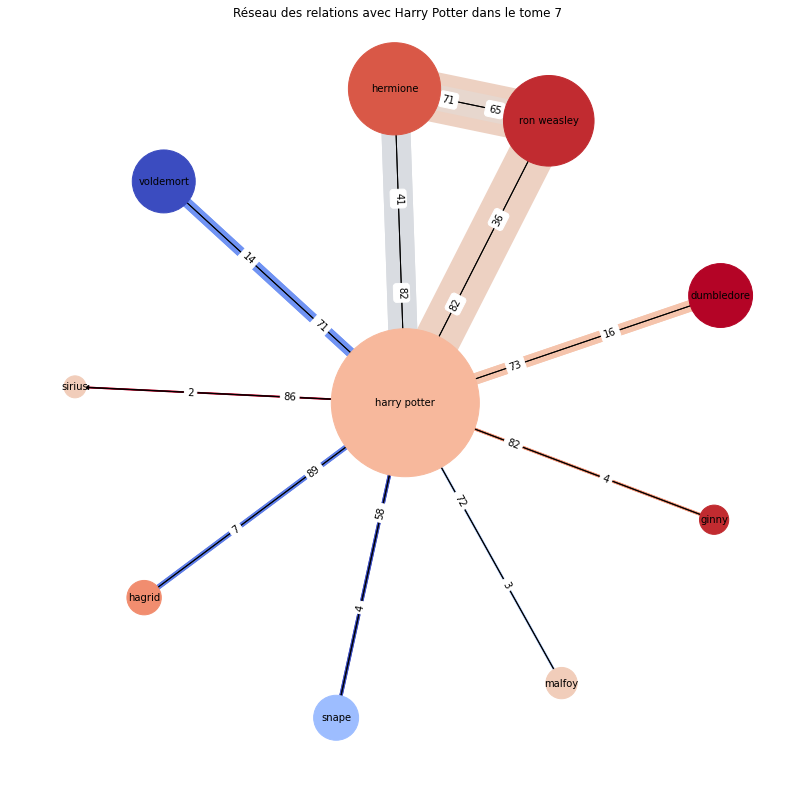

In [63]:
#On applique la fonction pour chaque tome
reseau(df1, occ_list[0], 1)
reseau(df2, occ_list[1], 2)
reseau(df3, occ_list[2], 3)
reseau(df4, occ_list[3], 4)
reseau(df5, occ_list[4], 5)
reseau(df6, occ_list[5], 6)
reseau(df7, occ_list[6], 7)

# Interprétation
La taille des noeuds est proportionnelle au nombre d'apparitions du personnage dans le livre.
La taille des flèches est proportionnelle au score de proximité la relation (du point de vue d'Harry Potter), cela correspond au nombre le plus proche du personnage cible. L'autre nombre correspon au score de proximité du point de vue de l'autre personnage.
La couleur des flèches correspond au score de positivité de la relation dans le livre: plus elle est rouge, plus elle est positive, plus elle est bleue, plus elle est évaluée comme négative.
La couleur des noeuds correspond à la moyenne du score de positivité de la relation durant toute la saga. Pour Harry Potter, cela correspond à la moyenne de ses relations durant toutes la saga. La couleur des noeuds ne change donc pas d'un livre à l'autre.
Nous avons fait le choix d'afficher la relation entre Ron et Hermione qui est à la fois très forte et qui connaît un certain rééquilibrage: au début la relation est plus importante du point de vue d'Hermione que du point de vue de Ron, peut-être car Ron apparaît plus dans les premiers tomes relativement à Hermione, puis cela se rééquilibre (comme du point du point de vue de leur nombre d'apparitions.

## Nuance sur l'analyse de sentiments

Maintenant que nous avons caractérisé la nature des relations entre les personnages, nous voulons mettre en perspective la positivité des sentiments pour voir s'il n'y a pas d'autres facteurs pouvant expliquer les tendances que semblent parfois suivre les interactions.

In [64]:
#Fonction similaire à la précédente calculant les scores mais donnant en sortie une 
#liste de scores de personnages pour chaque tome, pour permettre d'autres analyses

def sentiment_rel(perso_pdv, perso_cible):   #les arguments sont les listes d'index trouvées précédemment

    all_book_score = []
    i = 0
    
    for key in all_text_clean_list:
        all_score = []
        list_index = []
        for idx in perso_pdv[i]:
        #on considère que deux personnages ont une interaction s'ils sont à moins de 20 mots d'écart
            idx_bas = idx - 20
            idx_haut = idx + 20
        
            for index in perso_cible[i]: 
                if (idx_bas <= index <= idx_haut):
                    #liens += 1                     #si les index sont proches, on incrémente le compteur de liens
                    list_index.append([idx, index])
                    
                    grp = [word for word in all_text_clean_list[key] [min([idx, index])-20:max([idx, index])+20]] #i au lieu de book1
                    grp_join = ' '.join(grp)
                    score = sentiment_model.polarity_scores(grp_join)
                    compound_score = score['compound']
                    all_score.append(compound_score)
        i += 1
        if len(all_score)!= 0:
            all_book_score.append(moyenne(all_score))
        else: all_book_score.append(0)
    return all_book_score

In [65]:
#On l'applique pour toutes les relations d'Harry Potter

scores_persos = []
for perso in persos_occ_1:
    scores_persos.append(sentiment_rel(harry_occ,perso))
#scores_persos

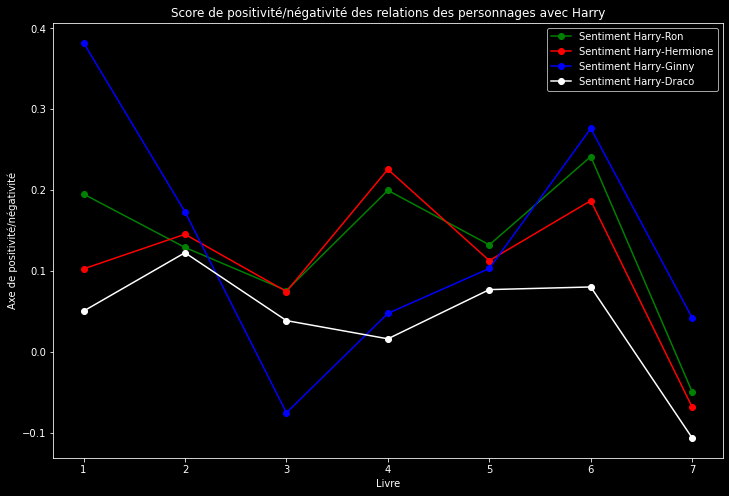

In [66]:
#Graphiques
x = np.linspace(1,7,7)
plt.figure(figsize=(12,8))

plt.title('Score de positivité/négativité des relations des personnages avec Harry', color = 'white')
plt.xlabel('Livre')
plt.ylabel('Axe de positivité/négativité')
plt.plot(x, scores_persos[0], marker = 'o', color = 'g', label = 'Sentiment Harry-Ron')
plt.plot(x, scores_persos[1], marker = 'o', color = 'r', label = 'Sentiment Harry-Hermione')
plt.plot(x, scores_persos[2], marker = 'o', color = 'b', label = 'Sentiment Harry-Ginny')
plt.plot(x, scores_persos[3], marker = 'o', color = 'white', label = 'Sentiment Harry-Draco')
plt.legend(loc = 'best', prop = {'size': 10})
plt.show()

In [ ]:
#Graphiques
x = np.linspace(1,7,7)
plt.figure(figsize=(12,8))

plt.title('Score de positivité/négativité des relations des personnages avec Harry', color = 'white')
plt.xlabel('Livre')
plt.ylabel('Axe de positivité/négativité')
plt.plot(x, scores_persos[4], marker = 'o', color = 'pink', label = 'Sentiment Harry-Voldemort')
plt.plot(x, scores_persos[5], marker = 'o', color = 'cyan', label = 'Sentiment Harry-Sirius')
plt.plot(x, scores_persos[6], marker = 'o', color = 'yellow', label = 'Sentiment Harry-Snape')
plt.plot(x, scores_persos[7], marker = 'o', color = 'brown', label = 'Sentiment Harry-Dumbledore')
plt.plot(x, scores_persos[8], marker = 'o', color = 'orange', label = 'Sentiment Harry-Hagrid')
plt.legend(loc = 'best', prop = {'size': 10})
plt.show()

Les deux graphiques montrent l'évolution du score de positivité des relations avec Harry Potter au fur et à mesure des livres.
Si tous ne sont pas au même niveau et ne connaissent pas la même évolution, on semble déceler un mouvement général. Et on se demande si ce n'est pas lié à l'atmosphère générale du livre, plus ou moins positive ou négative. On va donc essayer de voir la corrélation avec le score du livre.

In [ ]:
#Pour chaque livre, on calcule le score de positivité/négativité

book_scores = []
for i in all_text_clean:

    words = nltk.word_tokenize(all_text_clean[str(i)])

    # on regarde le score de chaque mot et on les somme
    all_scores = []    
    for word in words:
        scores = sentiment_model.polarity_scores(word)
        compound_score = scores['compound']
        all_scores.append(compound_score)

    # on fait la moyenne pour chaque livre à partir du score de chaque mot
    book_score = sum(all_scores) / len(all_scores)
    book_scores.append(book_score)

In [ ]:
#On peut maintenant calculer la corrélation entre le score des relations et le score total de chaque livre

r = np.corrcoef(scores_persos,book_scores)
sns.heatmap(data=r, annot=True)

On constate que les corrélations entre les relations et les scores des livres se situent sur la dernière colonne (il y a 8 relations et donc la colonne 9 est le score du livre). On voit donc que pour la plupart des relations, leur score de positivité est fortement corrélé à celui du livre. Les personnages vivant souvent ensemble les aventures, ils traversent les mêmes moments et donc il n'est pas étonnant qu'un livre avec de nombreux événements tristes comme le 7 pousse la plupart des scores de positivité vers le bas.

#### Conclusion 